# Parallelism in Computer Vision

## Setup

### Imports

In [21]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# for image loading
from PIL import Image
from pathlib import Path
import zipfile
import urllib.request
from typing import List
# for parallel processing
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

### Google Colab

In [ ]:
# Check if running of Google Colab
def is_running_on_colab():
    try:
        if 'google.colab' in str(get_ipython()): # type: ignore
            return True
        else:
            return False
    except NameError:
        return False

if is_running_on_colab():
    print("Running on Google Colab")

    # Check for available GPUs and, if found, configure TensorFlow to use memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # Ensure at least one GPU is available
        if physical_devices:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
            print("GPU memory growth enabled.")
        else:
            print("No GPU devices found.")
    except:
        print(f"Error setting GPU memory growth: {e}") # type: ignore
        pass

    # Get GPU infos
    gpu_info = !nvidia-smi # type: ignore
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

    # Connect to Google Drive
    from google.colab import drive # type: ignore
    drive.mount('/content/drive')

    # Setup the Google root
    root_path = "./drive/MyDrive/Project/Python_parallelism"

    # Install jiwer for the calculate_average_wer function
    ! pip install jiwer
else:
    print("Running on a local machine")
    # Setup the local root
    root_path = ".."

# Displays the number of avaible GPUs
print("\nNum GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Running on a local machine

Num GPUs Available:  0


2025-09-02 10:53:58.942561: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Global Variables and Data paths for Caltech101 dataset

Due to memory limitation on my computer, SAMPLE_SIZE is set to 5000 for the 3 first tests, then 1250.
To avoid kernel crash, tests are run by section, before restarting the kernel and running the next section.

In [4]:
SAMPLE_SIZE = 1250

DATA_ROOT = Path(root_path, "data")
ARCHIVE_URL = "https://www.kaggle.com/api/v1/datasets/download/imbikramsaha/caltech-101"
ARCHIVE_PATH = DATA_ROOT / "caltech101.zip"
EXTRACT_DIR = DATA_ROOT / "caltech-101"

print(f"Data folder set to {DATA_ROOT}")


Data folder set to ../data


### Tools

This decorator can be used on any function if measuring the execution time is needed.

In [ ]:
def time_it(func):
    """Decorator to measure execution time of functions."""
    def wrapper(*args, **kwargs):
        time_start = time.time()
        result = func(*args, **kwargs)
        time_end = time.time()
        print(f"{func.__name__} took {time_end - time_start:.4f}s")
        return result
    return wrapper

### Download Caltech101 dataset

In [5]:
def ensure_caltech101():
    if EXTRACT_DIR.exists() and any(EXTRACT_DIR.iterdir()):
        print("Caltech101 dataset already exists.")
        return
    print("Downloading Caltech101 archive...")
    urllib.request.urlretrieve(ARCHIVE_URL, ARCHIVE_PATH)
    print("Extracting Caltech101 archive...")
    with zipfile.ZipFile(ARCHIVE_PATH, "r") as zip_ref:
        zip_ref.extractall(path=DATA_ROOT)
    print("Caltech101 dataset extracted to", EXTRACT_DIR)

ensure_caltech101()


Caltech101 dataset already exists.


### Sample Images

In [ ]:
def sample_images(root: Path, limit=None) -> List[Path]:
    '''
    Create a list of image file paths from the given root directory.
    '''
    extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    paths = [path for path in root.rglob("*") if path.suffix.lower() in extensions]
    return paths[:limit] if limit else paths

paths = sample_images(EXTRACT_DIR, limit=None)
len(paths), paths[:5]


(9144,
 [PosixPath('../data/caltech-101/yin_yang/image_0042.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0002.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0053.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0009.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0019.jpg')])

## Preprocess Pipeline

### Resize, grayscale, Sobel edges.

In [6]:
def load_resize(path, size=(224,224)):
    """
    Open an image, convert it to RGB to ensure we have 3 channels, and resize it.
    Returns a NumPy array of shape (height, width, 3).
    """
    with Image.open(path) as img:
        img = img.convert("RGB").resize(size, Image.BILINEAR)
        return np.array(img, dtype=np.uint8)

def to_gray(img_rgb):
    """
    Convert an RGB image to grayscale using perceptual weights.
    Returns a NumPy array of shape (height, width).
    """
    # Use ellipsis (...) to select all pixels
    r, g, b = img_rgb[..., 0], img_rgb[..., 1], img_rgb[..., 2]
    # Apply ITU-R 601 to calculate luminance
    # Cast float32 to avoid overflow later
    return (0.299 * r + 0.587 * g + 0.114 * b).astype(np.float32)

def sobel_edges(img_gray):
    """
    Apply the Sobel operator to a grayscale image of shape (height, width) to detect edges.
    Returns a NumPy array of the same shape as the input image.
    """
    # Create two 3x3 Sobel kernels
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[ 1, 2, 1],
                        [ 0, 0, 0],
                        [-1,-2,-1]], dtype=np.float32)

    grad = np.pad(img_gray, ((1, 1), (1, 1)), mode='edge')
    grad_x = (
        grad[:-2, :-2] * sobel_x[0, 0] + grad[:-2, 1:-1] * sobel_x[0, 1] + grad[:-2, 2:] * sobel_x[0, 2] +
        grad[1:-1, :-2] * sobel_x[1, 0] + grad[1:-1, 1:-1] * sobel_x[1, 1] + grad[1:-1, 2:] * sobel_x[1, 2] +
        grad[2:, :-2] * sobel_x[2, 0] + grad[2:, 1:-1] * sobel_x[2, 1] + grad[2:, 2:] * sobel_x[2, 2]
    )
    grad_y = (
        grad[:-2, :-2] * sobel_y[0, 0] + grad[:-2, 1:-1] * sobel_y[0, 1] + grad[:-2, 2:] * sobel_y[0, 2] +
        grad[1:-1, :-2] * sobel_y[1, 0] + grad[1:-1, 1:-1] * sobel_y[1, 1] + grad[1:-1, 2:] * sobel_y[1, 2] +
        grad[2:, :-2] * sobel_y[2, 0] + grad[2:, 1:-1] * sobel_y[2, 1] + grad[2:, 2:] * sobel_y[2, 2]
    )
    return np.sqrt(grad_x**2 + grad_y**2).astype(np.float32)

## Serial Preprocessing

### Full dictionary

In [7]:
def preprocess_one(path, size=(224, 224), bins=32):
    """
    Preprocess pipeline for one image.
    Returns a dictionary containing components for reuse.
    """
    img_resized = load_resize(path, size)
    img_gray = to_gray(img_resized)
    img_edges = sobel_edges(img_gray)

    hists = []
    for channel in range(3):
        hist_channel, _ = np.histogram(img_resized[..., channel], bins=bins, range=(0, 255))
        hists.append(hist_channel.astype(np.float32))

    color_hist = np.concatenate(hists, axis=0)

    return {
        "path": str(path),
        "resized": img_resized,
        "gray": img_gray,
        "edges": img_edges,
        "color_hist": color_hist,
        "size": size,
        "bins": bins
    }

def preprocess_all_serial(image_paths, size=(224, 224), bins=32, limit=None):
    """
    Preprocess pipeline for a list of images.
    Returns a list of dictionaries, each containing components for reuse.
    """
    if limit is not None:
        image_paths = image_paths[:limit]
    return [preprocess_one(path, size=size, bins=bins) for path in image_paths]


### Minimal dictionary

In [ ]:
def preprocess_one_min(path, size=(224,224), bins=32):
    '''
    Preprocess pipeline for one image.
    Returns a minimal dictionary of features.
    '''
    img = load_resize(path, size)
    gray = to_gray(img)
    edges = sobel_edges(gray)
    # Simple feature: edge mean + color hist (density)
    hists = []

    for color in range(3):
        h, _ = np.histogram(img[..., color], bins=bins, range=(0,255), density=True)
        hists.append(h.astype(np.float32))
    color_hist = np.concatenate(hists)

    return {
        "path": str(path),
        "edge_mean": float(edges.mean()),
        "edge_max": float(edges.max()),
        "color_hist": color_hist
    }


### Performance test on different image size

In [ ]:
import time, statistics as stats

def measure_components(paths, limit=60, size=(224,224)):
    time_load = []
    time_compute = []

    if not limit:
        limit = len(paths)

    for p in paths[:limit]:
        t0 = time.perf_counter()
        img = load_resize(p, size=size)
        t1 = time.perf_counter()
        gray = to_gray(img)
        edges = sobel_edges(gray)
        t2 = time.perf_counter()
        time_load.append(t1 - t0)
        time_compute.append(t2 - t1)

    return {
        "n": limit,
        "load_mean": stats.mean(time_load),
        "compute_mean": stats.mean(time_compute),
        "load_total": sum(time_load),
        "compute_total": sum(time_compute)
    }


#### 224x224

In [15]:
component_stats_224 = measure_components(paths, limit=SAMPLE_SIZE, size=(224,224))
component_stats_224

{'n': 5000,
 'load_mean': 0.0035048333763821574,
 'compute_mean': 0.001687629114407173,
 'load_total': 17.524166881910787,
 'compute_total': 8.438145572035864}

#### 112x112

In [17]:
component_stats_112 = measure_components(paths, limit=SAMPLE_SIZE, size=(112,112))
component_stats_112

{'n': 5000,
 'load_mean': 0.0023690059279513663,
 'compute_mean': 0.0007657839100458659,
 'load_total': 11.84502963975683,
 'compute_total': 3.8289195502293296}

#### 56x56

In [19]:
component_stats_56 = measure_components(paths, limit=SAMPLE_SIZE, size=(56,56))
component_stats_56

{'n': 5000,
 'load_mean': 0.0021029290436330485,
 'compute_mean': 0.0005401675909852201,
 'load_total': 10.514645218165242,
 'compute_total': 2.700837954926101}

## Parallel Preprocessing

### Full dictionary

In [ ]:
def preprocess_parallel(paths, size=(224,224), bins=32, max_workers=None, limit=None):
    '''
    Preprocess pipeline using ProcessPoolExecutor for parallel processing.
    '''
    if limit: paths = paths[:limit]
    time_start = time.perf_counter()
    out = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(preprocess_one, path, size, bins) for path in paths]
        for f in as_completed(futures):
            out.append(f.result())

    time_end = time.perf_counter()
    elapsed = time_end - time_start

    return out, elapsed

par_samples, par_time = preprocess_parallel(paths, limit=SAMPLE_SIZE)
print(f"ProcessPool full objects: {len(par_samples)} images in {par_time:.2f}s")

ProcessPool full objects: 1250 images in 9.33s


### Minimal dictionary

In [ ]:
def preprocess_parallel_min(paths, size=(224,224), bins=32, max_workers=None, limit=None):
    '''
    Preprocess pipeline using ProcessPoolExecutor for parallel processing.
    Returns a minimal dictionary of features.
    '''
    if limit: paths = paths[:limit]
    time_start = time.perf_counter()
    out = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(preprocess_one_min, path, size, bins) for path in paths]
        for f in as_completed(futures):
            out.append(f.result())

    time_end = time.perf_counter()
    elapsed = time_end - time_start

    return out, elapsed

par_min_samples, par_min_time = preprocess_parallel_min(paths, limit=SAMPLE_SIZE)
print(f"ProcessPool minimal dict: {len(par_min_samples)} images in {par_min_time:.2f}s")

ProcessPool minimal dict: 1250 images in 6.82s


### Preprocessing using threads

In [ ]:
def preprocess_threads(paths, size=(224,224), bins=32, limit=None):
    '''
    Preprocess pipeline using ThreadPoolExecutor for parallel processing.
    '''
    if limit: paths = paths[:limit]

    time_start = time.perf_counter()

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda path: preprocess_one(path, size, bins), paths))

    time_end = time.perf_counter()
    elapsed = time_end - time_start

    return results, elapsed

thr_samples, thr_time = preprocess_threads(paths, limit=SAMPLE_SIZE)
print(f"ThreadPool: {len(thr_samples)} images in {thr_time:.2f}s")

ThreadPool: 1250 images in 15.67s


## Evaluating Process Speedup

In [ ]:
time_start = time.perf_counter()
serial_subset = preprocess_all_serial(paths, limit=SAMPLE_SIZE)
time_end = time.perf_counter()
serial_time = time_end - time_start
print(f"Serial ({SAMPLE_SIZE} images): {serial_time:.2f}s")

print(f"Speedups vs serial:")
print(f"  Processes (full objects): {serial_time / par_time:.2f}x")
print(f"  Processes (minimal dict): {serial_time / par_min_time:.2f}x")
print(f"  Threads: {serial_time / thr_time:.2f}x")

Serial (1250 images): 10.96s
Speedups vs serial:
  Processes (full objects): 1.17x
  Processes (minimal dict): 1.61x
  Threads: 0.70x


For a SAMPLE_SIZE of 1250 images, processes increase the preprocessing speed compared to serial, while threads decrease it.  
In this case, image preprocessing being CPU-bounded, threads do not improve preprocessing time.  
The decrease in time from threads preprocessing might be cause by overhead (thread creation and management, GIL contention, operating system switching between threads)

## Batch Preprocessing

In [ ]:
def worker(batch, size, bins):
    return [preprocess_one_min(p, size=size, bins=bins) for p in batch]

def preprocess_parallel_batches(paths, size=(224,224), bins=32, batch_size=16, max_workers=None, limit=None):
    if limit: paths = paths[:limit]
    batches = [paths[i:i+batch_size] for i in range(0, len(paths), batch_size)]

    time_start = time.perf_counter()
    first_future_submit = None
    first_result_time = None

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for batch in batches:
            if first_future_submit is None:
                first_future_submit = time.perf_counter()
            futures.append(executor.submit(worker, batch, size, bins))
        for i, f in enumerate(as_completed(futures)):
            result = f.result()
            if first_result_time is None:
                first_result_time = time.perf_counter()
            results.extend(result)

    time_end = time.perf_counter()

    return {
        "n_images": len(results),
        "total_time": time_end - time_start,
        "submit_overhead": (first_future_submit - time_start) if first_future_submit else None,
        "time_until_first_result": (first_result_time - time_start) if first_result_time else None,
        "batch size": batch_size,
        "max_workers": max_workers
    }


In [ ]:
stats_batch = preprocess_parallel_batches(paths, limit=SAMPLE_SIZE, batch_size=8)
stats_batch

{'n_images': 1250,
 'total_time': 10.015896146999694,
 'submit_overhead': 0.08358591099977275,
 'time_until_first_result': 2.1671027269999286,
 'batch size': 8,
 'max_workers': None}

### Explore the effect of batchsize on the preprocessing with ProcessPoolExecutor

In [11]:
batch_sizes = [4, 8, 16, 24, 32, 48]
sweep = []
for b in batch_sizes:
    s = preprocess_parallel_batches(paths, limit=SAMPLE_SIZE, batch_size=b)
    sweep.append(s)
    print(f"batch={b:2d} total={s['total_time']:.3f}s first_result={s['time_until_first_result']:.3f}s")

# Find best
best = min(sweep, key=lambda d: d['total_time'])
print("\nBest batch config:", best)

batch= 4 total=7.557s first_result=0.812s
batch= 8 total=6.916s first_result=0.464s
batch=16 total=5.770s first_result=0.637s
batch=24 total=5.795s first_result=0.833s
batch=32 total=5.781s first_result=1.109s
batch=48 total=6.153s first_result=1.999s

Best batch config: {'n_images': 1250, 'total_time': 5.770365031999972, 'submit_overhead': 0.0031104640002013184, 'time_until_first_result': 0.6368600789992342, 'batch size': 16, 'max_workers': None}


In [26]:
serial_time = 10.96
par_min_time = 6.82

print(f"Serial ({SAMPLE_SIZE} images): {serial_time:.2f}s")

print(f"Speedups vs serial:")
print(f"  Processes (batches): {serial_time / best['total_time']:.2f}x")
print(f"Speedups vs processes:")
print(f"  Processes (minimal dict): {par_min_time / best['total_time']:.2f}x")

Serial (1250 images): 10.96s
Speedups vs serial:
  Processes (batches): 1.90x
Speedups vs processes:
  Processes (minimal dict): 1.18x


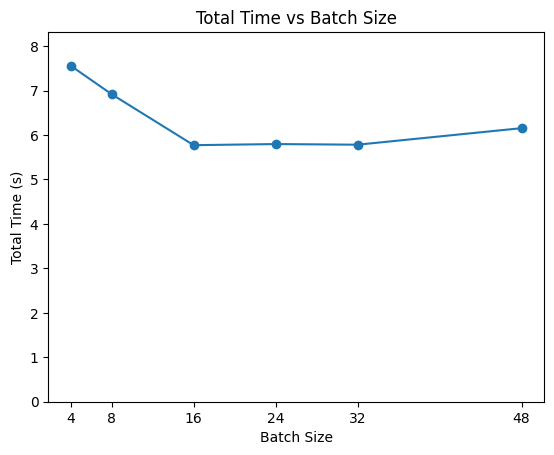

In [20]:
total_times = [d['total_time'] for d in sweep]

plt.plot(batch_sizes, total_times, marker='o')
plt.title("Total Time vs Batch Size")
plt.ylabel("Total Time (s)")
plt.xlabel("Batch Size")
plt.ylim(0, max(total_times) * 1.1)
plt.xticks(batch_sizes);
